In [291]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [292]:
# read trajectory data
data_path = "/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data"
atoms_selection = "name CA"
print("selected atoms:", atoms_selection)

# load data
prmtopFileName =  data_path + "/s1_init_protein_only.gro"
trajFiles = [data_path+"/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_atoms = coord.select_atoms(atoms_selection)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_atoms.n_atoms,3),dtype=float)
count = 0

# no need to multiply by 10
for ts in coord.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

selected atoms: name CA
['/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr']
1
Number of atoms in trajectory: 5835
Number of frames in trajectory: 21001
Number of atoms being analyzed: 375
Number of frames being analyzed: 21001


In [293]:
## load data from COLVAR
time, ld1, cleft_dist, dihedral, opes_bias = np.loadtxt(data_path+"/COLVAR_EDITED", usecols=(0,1,2,3,4), unpack=True)

time *= 1e-3 # in ns

In [294]:
print(min(ld1), max(ld1))

-40.14152285 40.28480364


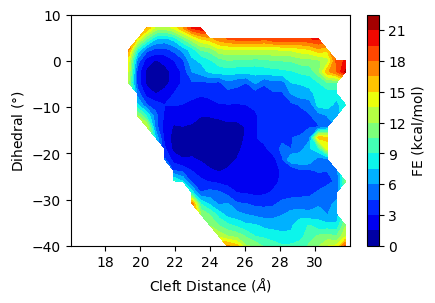

In [295]:
kbt=0.616033 # in kcal/mol unit
hist, xedges, yedges = np.histogram2d(cleft_dist*10.0, dihedral*180/3.14, bins=[25,25], density=True, weights=np.exp(opes_bias/kbt))
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe = -kbt*np.log(hist)
fe -= fe.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(4.5,3), dpi=100)
plt.xticks([18,20,22,24,26,28,30])
plt.xlim(16,32)
plt.ylim(-40,10)
plt.xlabel("Cleft Distance ($\\AA$)")
plt.ylabel("Dihedral ($\\degree$)")
#plt.contour(xx, yy, fe.T, cmap='binary', levels=10, linestyles="--")
plt.contourf(xx, yy, fe.T, cmap="jet", levels=20)
cbar = plt.colorbar()
cbar.set_label("FE (kcal/mol)")

In [296]:
ld1_grids = np.linspace(-41.0, 41.0, 100, endpoint=True)
dihedral_grids = np.linspace(-np.pi, np.pi, 100, endpoint=True)
print(ld1_grids.shape)

# load the final FE from final STATE file  (time=1050ns)
fe_state_final = np.loadtxt(data_path+"/2d_fe_actin_ld1+dihedral.dat", usecols=2).reshape([100,100])/4.184
print(fe_state_final.shape)

(100,)
(100, 100)


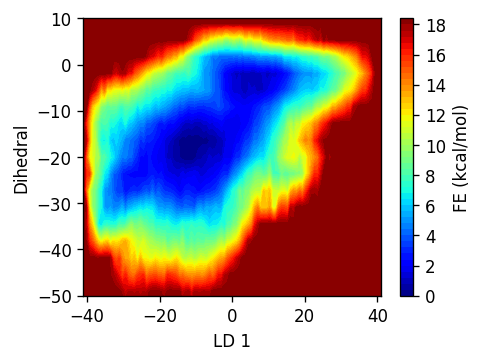

In [297]:
plt.figure(figsize=(4,3), dpi=120)
plt.ylim(-50.0,10)
plt.xlabel("LD 1")
plt.ylabel("Dihedral")
plt.contourf(ld1_grids, dihedral_grids*180/3.14, fe_state_final, cmap="jet", levels=50)
cbar=plt.colorbar()
cbar.set_label("FE (kcal/mol)")
#plt.scatter(ld1, dihedral*180/3.14, marker='.', s=0.02, color="k", alpha=0.06)

In [298]:
bin_counts, xedges, yedges =  np.histogram2d(ld1, dihedral, bins=[100,100], range=[[-41.0,41.0], [-np.pi, np.pi]])
print(bin_counts.shape)
print(np.sum(bin_counts))

(100, 100)
1050001.0


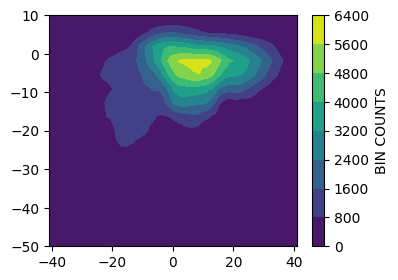

In [299]:
plt.figure(figsize=(4,3))
plt.ylim(-50,10)
plt.contourf(ld1_grids, dihedral_grids*180/3.14, bin_counts.T)
cbar = plt.colorbar()
cbar.set_label("BIN COUNTS")
#plt.scatter(ld1, dihedral*180/3.14, marker='.', s=0.01, color="r", alpha=0.5)

In [300]:
x_indx = np.digitize(ld1, ld1_grids, right=True)
y_indx = np.digitize(dihedral, dihedral_grids, right=True)

In [301]:
weights = np.empty(time.shape[0])

for i in range(time.shape[0]):
    weights[i] = np.exp(-fe_state_final.T[x_indx[i], y_indx[i]]/kbt)
    #weights[i] /= bin_counts[x_indx[i], y_indx[i]]

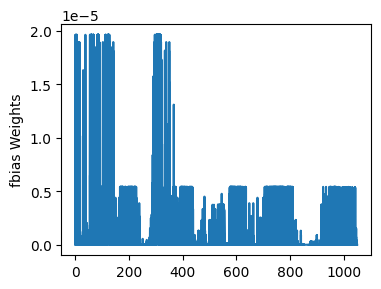

In [302]:
plt.figure(figsize=(4,3))
plt.ylabel("fbias Weights")
#plt.plot(time, weights)
plt.plot(time, weights/np.sum(weights))
#plt.plot(time, np.log(weights/np.sum(weights)))

### 2D FE obtained using fbias weights ->

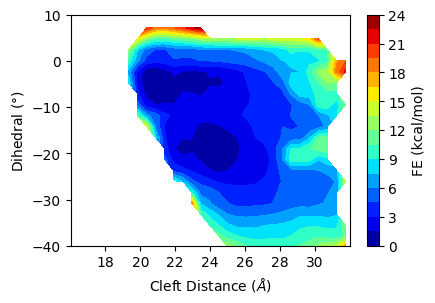

In [303]:
kbt=0.616033 # in kcal/mol unit
hist, xedges, yedges = np.histogram2d(cleft_dist*10.0, dihedral*180/3.14, bins=[25,25], density=True, weights=weights)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe = -kbt*np.log(hist)
fe -= fe.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(4.5,3), dpi=100)
plt.xticks([18,20,22,24,26,28,30])
plt.xlim(16,32)
plt.ylim(-40,10)
plt.xlabel("Cleft Distance ($\\AA$)")
plt.ylabel("Dihedral ($\\degree$)")
#plt.contour(xx, yy, fe.T, cmap='binary', levels=10, linestyles="--")
plt.contourf(xx, yy, fe.T, cmap="jet", levels=20)
cbar = plt.colorbar()
cbar.set_label("FE (kcal/mol)")

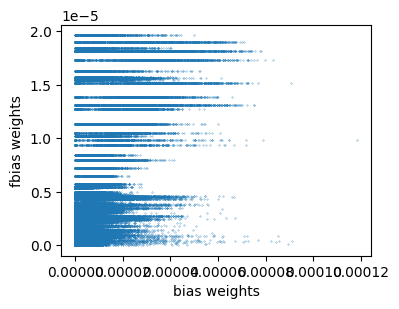

In [304]:
# bias weights
w_bias = np.exp(opes_bias/kbt)
w_bias /= np.sum(w_bias)

# fbias weights
w_fbias = weights/np.sum(weights)

plt.figure(figsize=(4,3), dpi=100)
plt.xlabel("bias weights")
plt.ylabel("fbias weights")
plt.scatter(w_bias, w_fbias, marker=".", s=0.2)

In [306]:
print(trajData.shape)
print(kbt)
#print(ld1_grids)
#print(dihedral_grids)

(21001, 375, 3)
0.616033
